In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import operator

import os
import sys
sys.path.append("../src") if "../src" not in sys.path else None 

# custom imports
from methods import *
from GenericDNN import GenericDNN
from swag import train_swag, inference_swag, sample_posterior_swag, monte_carlo_PI

### Initialize Data and Model

In [3]:
# choose dataset to use
dataset_name = 'yacht.txt'
datasets_path = '../datasets/'
dataset_path = datasets_path + dataset_name

# load data and create torch training data loader
(X_train, y_train), (X_test, y_test) = load_data(dataset_path)
trainloader = torch.utils.data.DataLoader(Dataset(X_train, y_train, dataset_name.split('.')[0]), 
                                         batch_size:=32, shuffle:=True)

# init model, criterion and optimizer
net = GenericDNN(input_size:=X_train.shape[-1], hidden_size:=input_size, output_size:=1)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Choose whether to train weights (SWAG), and do inference

In [144]:
# Set 'train:=True' if model not previously trained, or want to train a new model
checkpoint_path = '../checkpoints/'
if train:=False:
    # delete previous checkpoints for model with current dataset
    onlyfiles = [f for f in os.listdir(checkpoint_path) if os.path.isfile(os.path.join(checkpoint_path, f))]
    for file in onlyfiles:
        if trainloader.dataset.name in file:
            print(f"Deletes {file=}")
            os.remove(checkpoint_path + file)
    
    # train and save weights
    train_swag(
        net,
        trainloader,
        optimizer,
        criterion,
        init_epochs=1000,
        sampling_epochs=5,
        nsamples=200,
        path_to_checkpoints="../checkpoints/",
    )

# Do inference (infer approximate sample mean and covariance of an assumed Guassian posterior)
theta_SWA, cov_diag, D = inference_swag(trainloader.dataset.name)

### Try to sample some weights from the posterior distribution

In [148]:
# sample weights from the inferred approximate posterior distribution

# ----
# The beauty of this approach is that the returned weight-sample can
# be directly loaded into the model. i.e. by:
# 'net.load_state_dict(sample_posterior_swag(theta_SWA, cov_diag, D))'
# ----
sample_posterior_swag(theta_SWA, cov_diag, D)

OrderedDict([('fc1.weight',
              tensor([[-0.1999, -0.0791,  0.3942, -0.4994, -0.6365, -0.2056],
                      [-0.1365, -0.0495,  0.2243, -0.3310, -0.3824, -0.3242],
                      [ 0.3466,  0.2380, -0.4285,  0.3731,  0.5174,  1.6986],
                      [-0.2017, -0.2345,  0.4336, -0.1760, -0.3615, -0.5294],
                      [-0.2059, -0.0492,  0.0940,  0.0714, -0.0346, -2.1599],
                      [-0.0414,  0.0753, -0.2142,  0.3107,  0.2652, -2.5509]])),
             ('fc1.bias',
              tensor([ 0.4519,  0.6594, -0.7872,  1.3513,  0.9575,  2.7161])),
             ('fc2.weight',
              tensor([[-0.6573, -0.7069,  1.4609, -1.4453, -1.7629,  3.0561]])),
             ('fc2.bias', tensor([-3.6144]))])

In [178]:
Lpi, Upi, mu = monte_carlo_PI(trainloader.dataset[:][0], net, theta_SWA, cov_diag, D, nsamples=50, percentile=0.9)

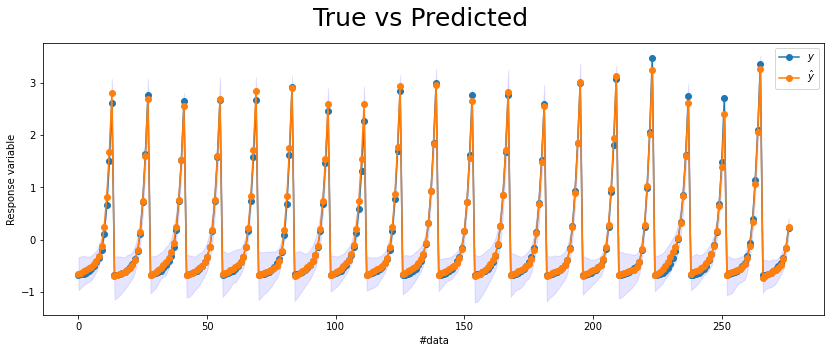

In [191]:



# plotting (OBSOBSOBS!! Dataset normalizes the data, thus plotted values are normalized!)
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(trainloader.dataset[:][1], "-o", label="$y$")
ax.plot(mu[:,0], "-o", label="$\hat{y}$")
ax.set_xlabel("#data")
ax.set_ylabel("Response variable")
ax.legend()
fig.suptitle("True vs Predicted", size=25)
ax.fill_between(np.arange(len(y_train)), Lpi[:,0], Upi[:,0], color='b', alpha=.1)